In [ ]:
np.repeat(['train','test'])

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
train_clean = pd.read_csv('hw4-trainingset-wsa2113.csv')
train = train_clean.copy()

/Users/barmfield/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (50,53,54,55,56,255,256,257,258,260,268,376) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test_clean = pd.read_csv('hw4-testset-wsa2113.csv')
test = test_clean.copy()

/Users/barmfield/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (50,255,256,257,258,260,268,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cb = pd.read_csv('CodeBook-SELECT.csv')

In [5]:
print('train shape:',train.shape)
print('test shape:',test.shape)
print('code book shape:',cb.shape)

train shape: (20000, 380)
test shape: (24500, 380)
code book shape: (379, 2)


## TODO:  
* create baseline
    * drop high null variables and rows
* Data cleaning
    * drop duplicate columns
        * cntryid, cntryid_e
        * drop cntryid, as it is less specific
    * drop cols w/ high null %
    * drop rows w/ high null %
    * add is_null column for each category where value was null
    * find cols with mixed types and correct
    * convert numerical columns to int or float from objects
    * categorical variables
        * OHC categorical variables
        * make sure dtypes match up across train and test
    * missing data
        * experiment imputing with mean and median
            * check distribution of data; if there are big outliers, use median, if not, use mean
        * check all cols which have missing data and see if that data should be captured in a new feature
    * feature scaling
        * **NOTE: split and scale at the same time**
        * normalization --> min/max scaler
        * standardization (z-score normalization)
        * api
            * column transformer
                * numeric transformer
                    * imputer
                    * scaler
                * categorical transformer
                    * imputer
                    * OHE
    * dimensionality reduction
        * PCA
    * normalizing
        * yeo-johnson power transformer

# Baseline
* Remove columns
    * Drop high % null cols and rows
        * Threshold = 75%
    * Drop columns unrelated to performance
    * Drop target


* Split data into train, val, and test sets

In [6]:
from sklearn.model_selection import train_test_split

X_train = train.drop(['uni','row','job_performance'], axis = 1)
y_train = train['job_performance']
X_test = test[X_train.columns]
y_test = test['job_performance']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 377)
(20000,)
(24500, 377)
(24500,)


In [7]:
y_train[:5]

0    3114.660665
1    2561.324500
2    2873.347766
3    2713.175295
4    2230.654274
Name: job_performance, dtype: float64

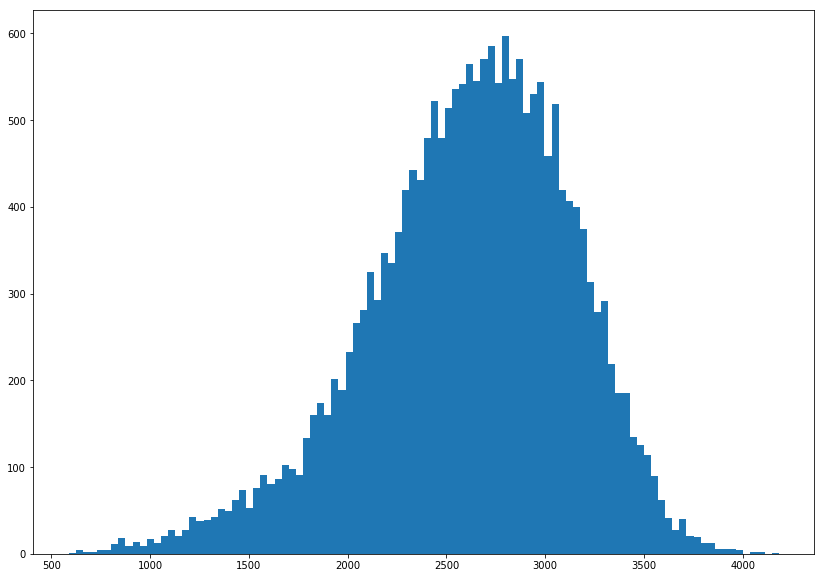

In [7]:
fig, ax = plt.subplots(figsize=(14,10))
_ = ax.hist(y_train, bins=100)

* Identify categorical and numerical columns

In [8]:
categorical_obj_cols = X_train.dtypes == object
cat_cols = categorical_obj_cols[categorical_obj_cols==True].index.values
num_cols = categorical_obj_cols[categorical_obj_cols==False].index.values



* Fix columns with multiple data types

In [9]:
for col in cat_cols:
    X_train[col] = X_train[col].astype('str')
    
for col in num_cols:
    X_train[col] = X_train[col].astype('float')

### Build pipeline
    * impute nulls
    * scale numerical columns
    * OHE categorical columns
    * Try with
        * Lasso
        * Ridge
        * RandomForestRegressor
        * SVM

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score

def try_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')
    print('Average MSE = {:.2f} +/- {:.2f}'.format(-np.mean(scores), np.std(scores)))
    
    
# missing_transform = 
num_transform = Pipeline(
    [
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler()),
        ('poly', PolynomialFeatures())
    ]
)

cat_transform = Pipeline(
    [
        ('nan_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('cat_scaler', StandardScaler(with_mean=False))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num', num_transform, ~categorical_obj_cols),
        ('cat', cat_transform, categorical_obj_cols),
    ]
)
    
# X_train_pr = preprocessor.fit_transform(X_train)

In [13]:
X_train_pr.shape

(20000, 6665)

#### Lasso

In [203]:
from sklearn.linear_model import LassoCV

lasso_alphas = np.logspace(-1, -.01, 10)
lasso = LassoCV(alphas=lasso_alphas, cv=3, max_iter=10000, n_jobs=-1, random_state=0)
lasso.fit(X_train_pr, y_train)

In [ ]:
lasso_data = np.hstack((lasso.mse_path_,lasso.alphas_[:,np.newaxis]))
lasso_data = np.hstack((lasso_data, 
                        np.array([lasso.alpha_ for _ in range(lasso.mse_path_.shape[0])])[:,np.newaxis]))
lasso_cols = ['cv_'+str(i) for i in range(lasso.mse_path_.shape[1])]
lasso_cols.append('alpha')
lasso_cols.append('best_alpha')
lasso_results = pd.DataFrame(data=lasso_data, columns=lasso_cols)
lasso_results.to_csv('lasso_results.csv')
lasso_results

In [16]:
from sklearn.linear_model import Lasso

best_lasso_alpha = 0.977237
best_lasso = Lasso(alpha=best_lasso_alpha, normalize=False, random_state=0)
scores = cross_val_score(best_lasso, X_train_pr, y_train, cv=3, scoring='neg_mean_squared_error')
print('Average MSE = {:.2f} +/- {:.2f}'.format(-np.mean(scores), np.std(scores)))

/Users/barmfield/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/barmfield/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/barmfield/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Average MSE = 124874.70 +/- 5820.21


#### Ridge

In [62]:
from sklearn.linear_model import RidgeCV

# ridge_alphas = np.logspace(-4, .01, 20)
ridge_alphas = np.linspace(900,1500,11)
ridge = RidgeCV(alphas=ridge_alphas, store_cv_values=True)
ridge.fit(X_train_pr, y_train)

RidgeCV(alphas=array([ 900.,  960., 1020., 1080., 1140., 1200., 1260., 1320., 1380.,
       1440., 1500.]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [67]:
ridge_cv_results = np.mean(ridge.cv_values_, axis=0)[:,np.newaxis]
ridge_data = np.hstack((ridge_cv_results,ridge_alphas[:,np.newaxis]))
ridge_data = np.hstack((ridge_data, 
                        np.array([ridge.alpha_ for _ in range(ridge_data.shape[0])])[:,np.newaxis]))
ridge_cols = ['mse','alpha','best_alpha']
ridge_results = pd.DataFrame(data=ridge_data, columns=ridge_cols)
ridge_results.to_csv('ridge_results.csv')

In [65]:
from sklearn.linear_model import Ridge

best_ridge_alpha = ridge.alpha_
best_ridge = Ridge(alpha=best_ridge_alpha, random_state=0)
scores = cross_val_score(best_ridge, X_train_pr, y_train, cv=3, scoring='neg_mean_squared_error')
print('Average MSE = {:.2f} +/- {:.2f}'.format(-np.mean(scores), np.std(scores)))

Average MSE = 366209.79 +/- 314504.76


#### RF Regressor  
* Guidance on gridsearching RandomForestRegressor : https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

rfr = RandomForestRegressor()

rscv = RandomizedSearchCV(
    rfr,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=0
)

rscv.fit(X_train_pr, y_train)

In [ ]:
rf_results=pd.DataFrame(rscv.cv_results)
rf_results.to_csv('rf_results.csv')

In [ ]:
rf_results

#### XGBoost

In [68]:
import xgboost as xgb

Xy_train_xgb = xgb.DMatrix(data=X_train_pr, label=y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=Xy_train_xgb, params=params, nfold=3, num_boost_round=50,
                    early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

mse = cv_results["test-rmse-mean"].tail(1).values[0]**2
print('Average MSE = {:.2f}'.format(mse))

/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Average MSE = 120600.63


## Take 2  
* univariate statistics
* Incorporate PCA into pipeline
* Create new encoding for high cardinality categorical columns
* add missing value column for np.nan values
* Add feature interactions for numerical columns
* bootstrapping
* complex imputer
* Grid search best models from baseline
* Normalize data with yeo-johnson power transformer
* perutation importance for features? AML lec 12
* try tensor flow?
* sklearn missing indicator
* run on databricks

#### Updated Preprocessing
* iterative imputer
* binary "missing" feature cols

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

def try_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')
    print('Average MSE = {:.2f} +/- {:.2f}'.format(-np.mean(scores), np.std(scores)))
    
    
num_transform = Pipeline(
    [
        ('num_imputer', IterativeImputer(n_nearest_features=5, random_state=0, add_indicator=True,
                                         max_iter=100)),
        ('num_scaler', StandardScaler()),
        ('poly', PolynomialFeatures())
    ]
)

cat_transform = Pipeline(
    [
#         ('cat_imputer', IterativeImputer(n_nearest_features=5, initial_strategy='most_frequent', 
#          add_indicator=True, random_state=0)),
        ('nan_imputer', SimpleImputer(strategy='constant', fill_value='missing', add_indicator=True)),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('cat_scaler', StandardScaler(with_mean=False))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num', num_transform, ~categorical_obj_cols),
        ('cat', cat_transform, categorical_obj_cols),
    ]
)
    
X_train_pr = preprocessor.fit_transform(X_train)

/Users/barmfield/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


#### Truncated SVD  
* I want to try to lower the dimensionality of my data, both to increase speed of training, and hopefully to increase accuracy

In [16]:
X_train_pr.shape

(20000, 16066)

In [13]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=X_train_pr.shape[1]-1)
X_tsvd = tsvd.fit(X_train_pr)
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [ ]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

select_n_components(tsvd_var_ratios, 0.99)

In [20]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=1495, random_state=4771)
X_tsvd = tsvd.fit_transform(X_train_pr)

In [21]:
X_tsvd.shape

(20000, 1495)

In [22]:
import xgboost as xgb

Xy_train_xgb = xgb.DMatrix(data=X_tsvd, label=y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=Xy_train_xgb, params=params, nfold=3, num_boost_round=50,
                    early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=0)

mse = cv_results["test-rmse-mean"].tail(1).values[0]**2
print('Average MSE = {:.2f}'.format(mse))

/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Average MSE = 153882.99


In [23]:
Xy_train_xgb = xgb.DMatrix(data=X_train_pr, label=y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'min_child_weight': 1,
          'alpha': 10,
          'eta':0.1,
          'subsample': 1
         }

cv_results = xgb.cv(dtrain=Xy_train_xgb, 
                    params=params, 
                    nfold=3, 
                    num_boost_round=999,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=0)

mse = cv_results["test-rmse-mean"].tail(1).values[0]**2
print('Average MSE = {:.2f}'.format(mse))

Average MSE = 119662.11


#### Grid Searching xgboost

In [ ]:
Xy_train_xgb = xgb.DMatrix(data=X_train_pr, label=y_train)


gs_params = []
for d in [9,10,11]:
    for w in [5,6,7]:
        gs_params.append((d,w))
    


xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10}

cv_results = xgb.cv(dtrain=Xy_train_xgb, 
                    params=params, 
                    nfold=3, 
                    num_boost_round=999,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=0)

mse = cv_results["test-rmse-mean"].tail(1).values[0]**2
print('Average MSE = {:.2f}'.format(mse))

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [10]:
# high cardinality cols
for col in cat_cols:
    if len(train[col].unique()) > 50:
        print(col)


lng_home
cnt_h
cnt_brth
reg_tl2
v272
v52
v184
v104
v135
v235
v1
v63
v87
v239
v224
v71
v105
isic2l
isic2c
isco2c
isco2l
